Gauss-Seidel converged in 4321 iterations


<ipython-input-6-474f24bb4d28>:60: ComplexWarning: Casting complex values to real discards the imaginary part
  d_prime[0] = d[0]/b[0]
<ipython-input-6-474f24bb4d28>:65: ComplexWarning: Casting complex values to real discards the imaginary part
  d_prime[i] = (d[i] - a[i-1]*d_prime[i-1])/denominator
<ipython-input-6-474f24bb4d28>:67: ComplexWarning: Casting complex values to real discards the imaginary part
  d_prime[-1] = (d[-1] - a[-2]*d_prime[-2])/(b[-1] - a[-2]*c_prime[-2])


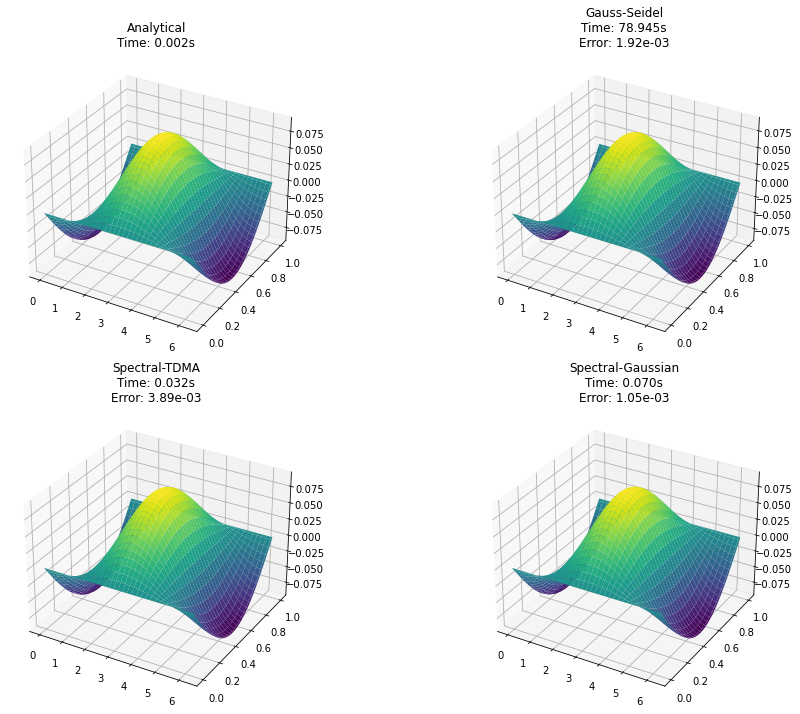


Detailed Comparison:

Computation Times:
Analytical: 0.002 seconds
Gauss-Seidel: 78.945 seconds
Spectral-TDMA: 0.032 seconds
Spectral-Gaussian: 0.070 seconds

Maximum Absolute Errors (vs Analytical):
Gauss-Seidel: 1.92e-03
Spectral-TDMA: 3.89e-03
Spectral-Gaussian: 1.05e-03


In [6]:
import numpy as np
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

def analytical_solver(x, z, L, H, nx=None, nz=None):
    """
    Analytical solution for ∇²φ = sin(πz/H)cos(2πx/L)
    nx, nz are included for signature consistency but not used
    """
    X, Z = np.meshgrid(x, z)
    kx = 2*np.pi/L
    kz = np.pi/H
    return -np.sin(kz*Z)*np.cos(kx*X)/(kx**2 + kz**2)

def gauss_seidel_solver(x, z, L, H, nx, nz, tol=1e-6, max_iter=10000):
    """
    Gauss-Seidel iteration method
    """
    dx = L/nx
    dz = H/nz
    dx2, dz2 = dx**2, dz**2
    
    X, Z = np.meshgrid(x, z)
    source = np.sin(np.pi*Z/H)*np.cos(2*np.pi*X/L)
    phi = np.zeros_like(X)
    
    for it in range(max_iter):
        old_phi = phi.copy()
        
        for i in range(1, nz):
            for j in range(1, nx):
                phi[i,j] = ((phi[i+1,j] + phi[i-1,j])*dx2 + 
                           (phi[i,j+1] + phi[i,j-1])*dz2 - 
                           dx2*dz2*source[i,j])/(2*(dx2 + dz2))
        
        # Boundary conditions
        phi[:,0] = phi[:,-2]
        phi[:,-1] = phi[:,1]
        phi[0,:] = 0
        phi[-1,:] = 0
        
        if np.max(np.abs(phi - old_phi)) < tol:
            print(f"Gauss-Seidel converged in {it+1} iterations")
            break
            
    return phi

def tdma_solver(a, b, c, d):
    """
    Tri-Diagonal Matrix Algorithm (Thomas Algorithm)
    """
    n = len(d)
    c_prime = np.zeros(n-1)
    d_prime = np.zeros(n)
    
    # Forward elimination
    c_prime[0] = c[0]/b[0]
    d_prime[0] = d[0]/b[0]
    
    for i in range(1, n-1):
        denominator = (b[i] - a[i-1]*c_prime[i-1])
        c_prime[i] = c[i]/denominator
        d_prime[i] = (d[i] - a[i-1]*d_prime[i-1])/denominator
    
    d_prime[-1] = (d[-1] - a[-2]*d_prime[-2])/(b[-1] - a[-2]*c_prime[-2])
    
    # Back substitution
    x = np.zeros(n)
    x[-1] = d_prime[-1]
    
    for i in range(n-2, -1, -1):
        x[i] = d_prime[i] - c_prime[i]*x[i+1]
        
    return x

def spectral_tdma_solver(x, z, L, H, nx, nz):
    """
    Semi-spectral method using FFT in x and TDMA in z
    """
    X, Z = np.meshgrid(x, z)
    source = np.sin(np.pi*Z/H)*np.cos(2*np.pi*X/L)
    
    # Take FFT in x direction
    source_hat = fft(source, axis=1)
    phi_hat = np.zeros_like(source_hat, dtype=complex)
    
    dz = H/nz
    kx = 2*np.pi*np.fft.fftfreq(nx+1, L/(nx+1))
    
    # For each Fourier mode, solve ODE in z
    for k in range(nx+1):
        # Skip k=0 mode as it should be 0 due to boundary conditions
        if abs(kx[k]) < 1e-10:
            continue
            
        # Set up tridiagonal system
        a = np.ones(nz-1)/dz**2  # lower diagonal
        b = -2/dz**2 - kx[k]**2 * np.ones(nz)  # main diagonal
        c = np.ones(nz-1)/dz**2  # upper diagonal
        d = source_hat[1:-1,k]  # RHS (removed negative sign)
        
        # Apply boundary conditions
        d[0] -= 0/dz**2  # phi[0] = 0
        d[-1] -= 0/dz**2  # phi[-1] = 0
        
        # Solve using TDMA
        phi_hat[1:-1,k] = tdma_solver(a, b[1:-1], c, d)
    
    # Take inverse FFT
    phi = np.real(ifft(phi_hat, axis=1))
    
    # Enforce boundary conditions
    phi[0,:] = 0
    phi[-1,:] = 0
    
    return phi

def gaussian_elimination_solver(x, z, L, H, nx, nz):
    """
    Semi-spectral method using FFT in x and Gaussian elimination in z
    """
    X, Z = np.meshgrid(x, z)
    source = np.sin(np.pi*Z/H)*np.cos(2*np.pi*X/L)
    
    # Take FFT in x direction
    source_hat = fft(source, axis=1)
    phi_hat = np.zeros_like(source_hat, dtype=complex)
    
    dz = H/nz
    kx = 2*np.pi*np.fft.fftfreq(nx+1, L/(nx+1))
    
    # For each Fourier mode, solve ODE in z
    for k in range(nx+1):
        # Skip k=0 mode as it should be 0 due to boundary conditions
        if abs(kx[k]) < 1e-10:
            continue
            
        # Set up system matrix
        A = np.diag(-2*np.ones(nz-1)/dz**2 - kx[k]**2) + \
            np.diag(np.ones(nz-2)/dz**2, 1) + \
            np.diag(np.ones(nz-2)/dz**2, -1)
        b = source_hat[1:-1,k]  # RHS (removed negative sign)
        
        # Apply boundary conditions
        b[0] -= 0/dz**2  # phi[0] = 0
        b[-1] -= 0/dz**2  # phi[-1] = 0
        
        # Solve using numpy's linear solver
        phi_hat[1:-1,k] = np.linalg.solve(A, b)
    
    # Take inverse FFT
    phi = np.real(ifft(phi_hat, axis=1))
    
    # Enforce boundary conditions
    phi[0,:] = 0
    phi[-1,:] = 0
    
    return phi

def compare_solutions(nx=100, nz=100):
    """
    Compare all solution methods
    """
    # Domain setup
    L = 2*np.pi
    H = 1.0
    x = np.linspace(0, L, nx+1)
    z = np.linspace(0, H, nz+1)
    
    methods = {
        'Analytical': analytical_solver,
        'Gauss-Seidel': gauss_seidel_solver,
        'Spectral-TDMA': spectral_tdma_solver,
        'Spectral-Gaussian': gaussian_elimination_solver
    }
    
    solutions = {}
    times = {}
    errors = {}
    
    # Compute solutions and timing
    for name, solver in methods.items():
        start_time = time.time()
        solutions[name] = solver(x, z, L, H, nx, nz)
        times[name] = time.time() - start_time
        
        if name != 'Analytical':
            errors[name] = np.max(np.abs(solutions[name] - solutions['Analytical']))
    
    # Plotting
    fig = plt.figure(figsize=(15, 10))
    
    # Plot solutions
    for i, (name, sol) in enumerate(solutions.items(), 1):
        ax = fig.add_subplot(2, 2, i, projection='3d')
        X, Z = np.meshgrid(x, z)
        surf = ax.plot_surface(X, Z, sol, cmap='viridis')
        ax.set_title(f'{name}\nTime: {times[name]:.3f}s')
        if name != 'Analytical':
            ax.set_title(f'{name}\nTime: {times[name]:.3f}s\nError: {errors[name]:.2e}')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print("\nDetailed Comparison:")
    print("\nComputation Times:")
    for name, t in times.items():
        print(f"{name}: {t:.3f} seconds")
    
    print("\nMaximum Absolute Errors (vs Analytical):")
    for name, err in errors.items():
        print(f"{name}: {err:.2e}")

# Run comparison
if __name__ == "__main__":
    compare_solutions(nx=100, nz=100)